In [51]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [52]:
imgRaw = cv.imread("mclovin.jpg")

Changes the channels so they are in the same order as the original image

In [53]:
imgOriginal = cv.cvtColor(imgRaw, cv.COLOR_BGR2RGB)

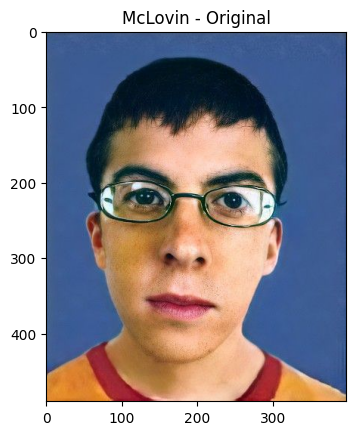

In [54]:
plt.imshow(imgOriginal)
plt.title("McLovin - Original")
plt.show()

<hr />

### Enhancing

#### Histogram Equalization

##### Independent Equalization on All Channels

In [55]:
rgbChannels = cv.split(imgOriginal)

rgbChannelsEqualized = [cv.equalizeHist(ch) for ch in rgbChannels]
imgOriginal_Equalized = cv.merge(rgbChannelsEqualized)

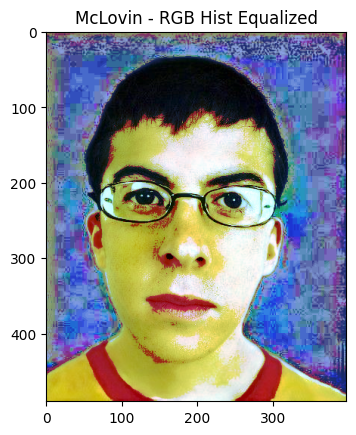

In [56]:
plt.imshow(imgOriginal_Equalized)
plt.title("McLovin - RGB Hist Equalized")
plt.show()

##### Equalization on V Channel

In [57]:
imgHSV = cv.cvtColor(imgRaw, cv.COLOR_BGR2HSV)

In [58]:
h, s, v = cv.split(imgHSV)
vEqualized = cv.equalizeHist(v)
imgHSV = cv.merge([h, s, vEqualized])
imgEqualized_vChannel = cv.cvtColor(imgHSV, cv.COLOR_HSV2RGB)

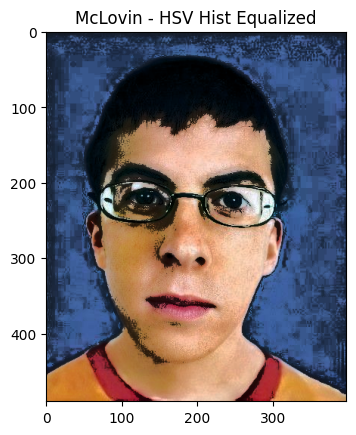

In [59]:
plt.imshow(imgEqualized_vChannel)
plt.title("McLovin - HSV Hist Equalized")
plt.show()

#### Gamma Enhancing

##### Low Intensity Areas

##### High Intensity Areas

<hr />

#### Edge Detection